# 生存時間分析
## 〜薬物利用から次の利用までの経過時間に関する時間分析〜

# 環境設定
本分析では、pipenvでの環境構築を行う
```bash
# Python: 3.11.7を利用した
pipenv --python 3.11.7
pipenv shell
pip install -r requirements.txt
```

In [129]:
from SurvSet.data import SurvLoader
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import numpy as np
import missingno as msno
from ydata_profiling import ProfileReport
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter

# データセットの読み込みとcsv形式での保存
- 本分析では、**麻薬中毒者の再使用に関するデータ**をSurvSetから利用した。
- csvでの保存は、`src` に保存される


In [ ]:

#^ データセットの種類を取得
loader = SurvLoader()

#^ データセットの名前を取得してファイルに保存
list = loader.df_ds.ds
input = ""
for ds in list:
    input += ds+"\n"
with open("src/df_ds_name.txt", "w") as f:
    f.write(input)

#^ 麻薬中毒者の再使用に関するデータセットを読み込むみ、一応csvファイルとして保存する
df, ref = loader.load_dataset(ds_name="uis").values()
with open("src/uis_data.csv", "w") as f:
    f.write(df.to_csv(index=True))
with open("src/uis_ref.txt", "w") as f:
    f.write(ref)

# 探索的データ分析

## データフレームの形式や基本統計量の把握

## Ref
```txt
Description of the variables in the UIS Study described in Table 1.3
 of Hosmer, D.W. and Lemeshow, S. and May, S. (2008) Applied Survival
 Analysis: Regression Modeling of Time to Event Data: Second Edition,
John Wiley and Sons Inc., New York, NY


Data are in the file uis.dat

n = 628


Variable      Description                       Codes/Values                日本語での解説(col_name)
id            Identification Code               1 - 628                     通し番号(time)
age           Age at Enrollment                 Years                       年齢(num_age)
beck          Beck Depression Score             0.000 - 54.000              ベック抑うつスコア(num_beck)
                                                                            [指標に関して関連](https://www.sannoclinic.jp/bdi.html)
                at Admission
hercoc        Heroin/Cocaine Use During         1 = Heroin & Cocaine        ヘロイン, コカイン使用状況(fac_heroic)
                3 Months Prior to Admission     2 = Heroin Only
                                                3 = Cocaine Only
                                                4 = Neither Heroin
                                                    nor Cocaine
ivhx          IV Drug Use History at            1 = Never                   静脈注射薬利用歴(fac_ivhx)
                Admission                       2 = Previous
                                                3 = Recent
ndrugtx       Number of Prior Drug              0 - 40                      過去の薬物治療回数(num_ndrugtx)
                Treatments
race          Subject's Race                    0 = White                   人種(fac_race)
                                                1 = Other
treat         Treatment Randomization           0 = Short                   治療ランダム割り付け_治療期間の長さ(fac_treat)
                Assignment                      1 = Long
site          Treatment Site                    0 = A                       治療施設(fac_site)
                                                1 = B
time          Time to Return to Drug Use        Days                        薬物再使用までの期間(time)
                (Measured from Admission)
event         Returned to Drug Use              1 = Returned to Drug Use    薬物再使用の有無(event)
                                                0 = Otherwise
```

### 先頭3行確認

In [120]:
df.head(3)

Unnamed: 0  event  time  fac_heroic  fac_ivhx  fac_race  fac_treat  \
0           0      1   188         4.0       3.0       0.0          1   
1           1      1    26         4.0       2.0       0.0          1   
2           2      1   207         2.0       3.0       0.0          1   

   fac_site  num_age  num_beck  num_ndrugtx  
0         0     39.0       9.0          1.0  
1         0     33.0      34.0          8.0  
2         0     33.0      10.0          3.0

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   pid          628 non-null    int64   
 1   event        628 non-null    int64   
 2   time         628 non-null    int64   
 3   fac_heroic   628 non-null    category
 4   fac_ivhx     628 non-null    category
 5   fac_race     628 non-null    category
 6   fac_treat    628 non-null    category
 7   fac_site     628 non-null    category
 8   num_age      623 non-null    float64 
 9   num_beck     595 non-null    float64 
 10  num_ndrugtx  611 non-null    float64 
dtypes: category(5), float64(3), int64(3)
memory usage: 32.8 KB


In [80]:
col_list = df.columns.tolist()

In [81]:
df.isnull().sum()

pid             0
event           0
time            0
fac_heroic      0
fac_ivhx        0
fac_race        0
fac_treat       0
fac_site        0
num_age         5
num_beck       33
num_ndrugtx    17
dtype: int64

<Axes: >

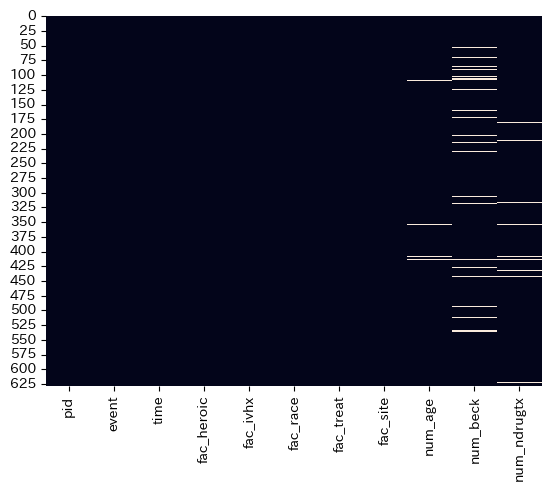

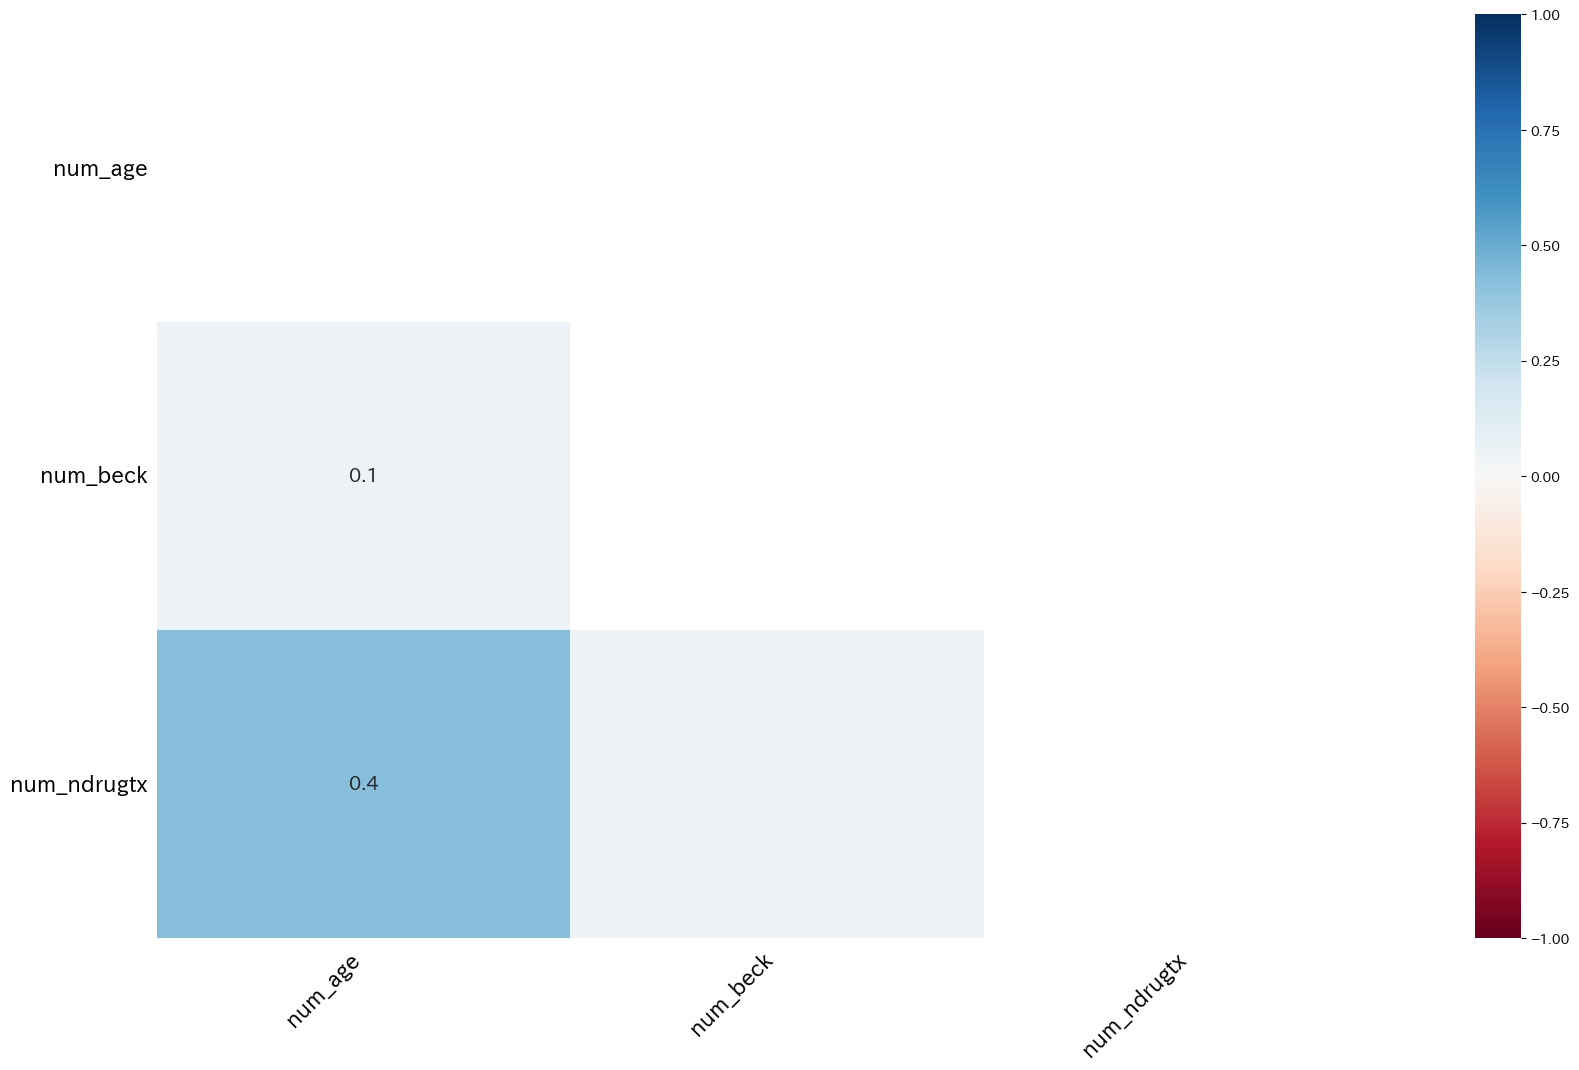

In [82]:
sns.heatmap(df.isnull(), cbar=False)
msno.heatmap(df)

### カテゴリ変数でない列の基本統計量

In [83]:
df.describe()

pid       event         time     num_age    num_beck  \
count  628.000000  628.000000   628.000000  623.000000  595.000000   
mean   313.500000    0.808917   234.703822   32.369181   17.404855   
std    181.432265    0.393468   201.701126    6.119534    9.391132   
min      0.000000    0.000000     2.000000   20.000000    0.000000   
25%    156.750000    1.000000    79.000000   27.000000   10.000000   
50%    313.500000    1.000000   166.000000   32.000000   17.000000   
75%    470.250000    1.000000   365.250000   37.000000   23.000000   
max    627.000000    1.000000  1172.000000   56.000000   54.000000   

       num_ndrugtx  
count   611.000000  
mean      4.574468  
std       5.494462  
min       0.000000  
25%       1.000000  
50%       3.000000  
75%       6.000000  
max      40.000000

## 割合の把握

- eventについて   
    0が未再使用, 1が再使用になる。
    - 未再使用等:薬物1回目の使用後に、2回目の利用が観察期間内に観察できていない個体 
    - 再使用: 薬物1回目の使用後に、2回目の利用を観察期間内に観察できた個体
- グラフからわかること
    - 再使用等が80.9%であり、ほとんどの薬物使用者が複数回の利用を行っていることがわかる。
    - 治療の有無により変化しているかは、このグラフからは検討できない

event
1    508
0    120
Name: count, dtype: int64


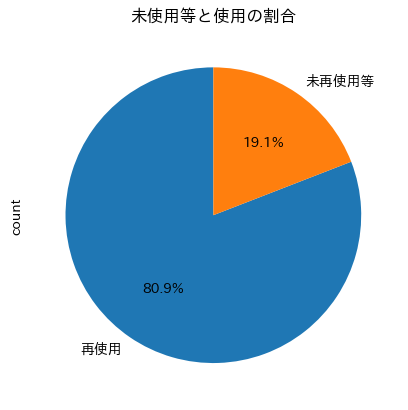

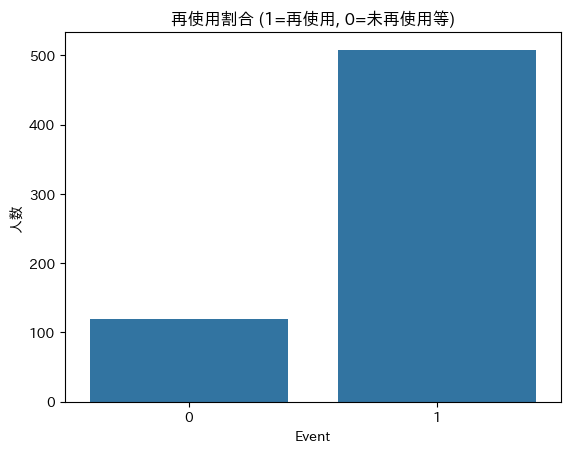

In [84]:
print(df['event'].value_counts())

# グラフ化
df['event'].value_counts().plot.pie(autopct='%1.1f%%', labels=['再使用', '未再使用等'], startangle=90)
plt.title('未使用等と使用の割合')
plt.show()

sns.countplot(x='event', data=df)
plt.title('再使用割合 (1=再使用, 0=未再使用等)')
plt.xlabel('Event')
plt.ylabel('人数')
plt.show()

## 薬物再使用と時間の関係
- 全観察対象のうち、event==1であるレコードを抽出し、
- 1回目利用直後が最も高く、徐々に減少傾向であるとうかがえる。


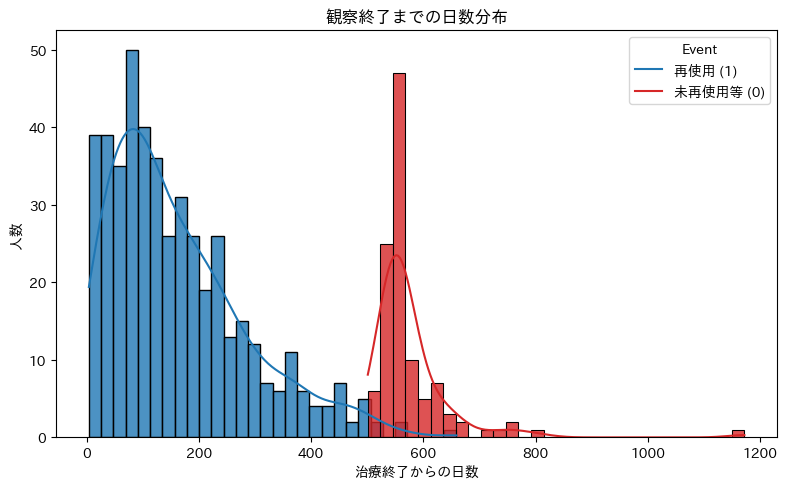

In [113]:
df_event1 = df[df["event"] == 1]    # 列名が censor の場合は df["censor"] == 1
df_event0 = df[df["event"] == 0]
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_event1,
    x="time",
    bins=30,
    kde=True,
    stat="count",
    color="tab:blue",
    edgecolor="black",
    alpha=0.8
)
sns.histplot(
    data=df_event0,
    x="time",
    bins=30,
    kde=True,
    stat="count",
    color="tab:red",
    edgecolor="black",
    alpha=0.8
)
plt.title("観察終了までの日数分布")
plt.xlabel("治療終了からの日数")
plt.legend(title='Event', labels=['再使用 (1)', '未再使用等 (0)'])
plt.ylabel("人数")
plt.tight_layout()
plt.savefig("output/plot/観察終了までの時間分布.png")
plt.show()

## 調査対象者の分布
- num_age(年齢)について   
    30代前半での調査対象者割合が多い
- num_beckについて
- num_ndrugtxについて
- timeについて
    - 打ち切りタイミングは、500日以降から順次観測されている
    - 

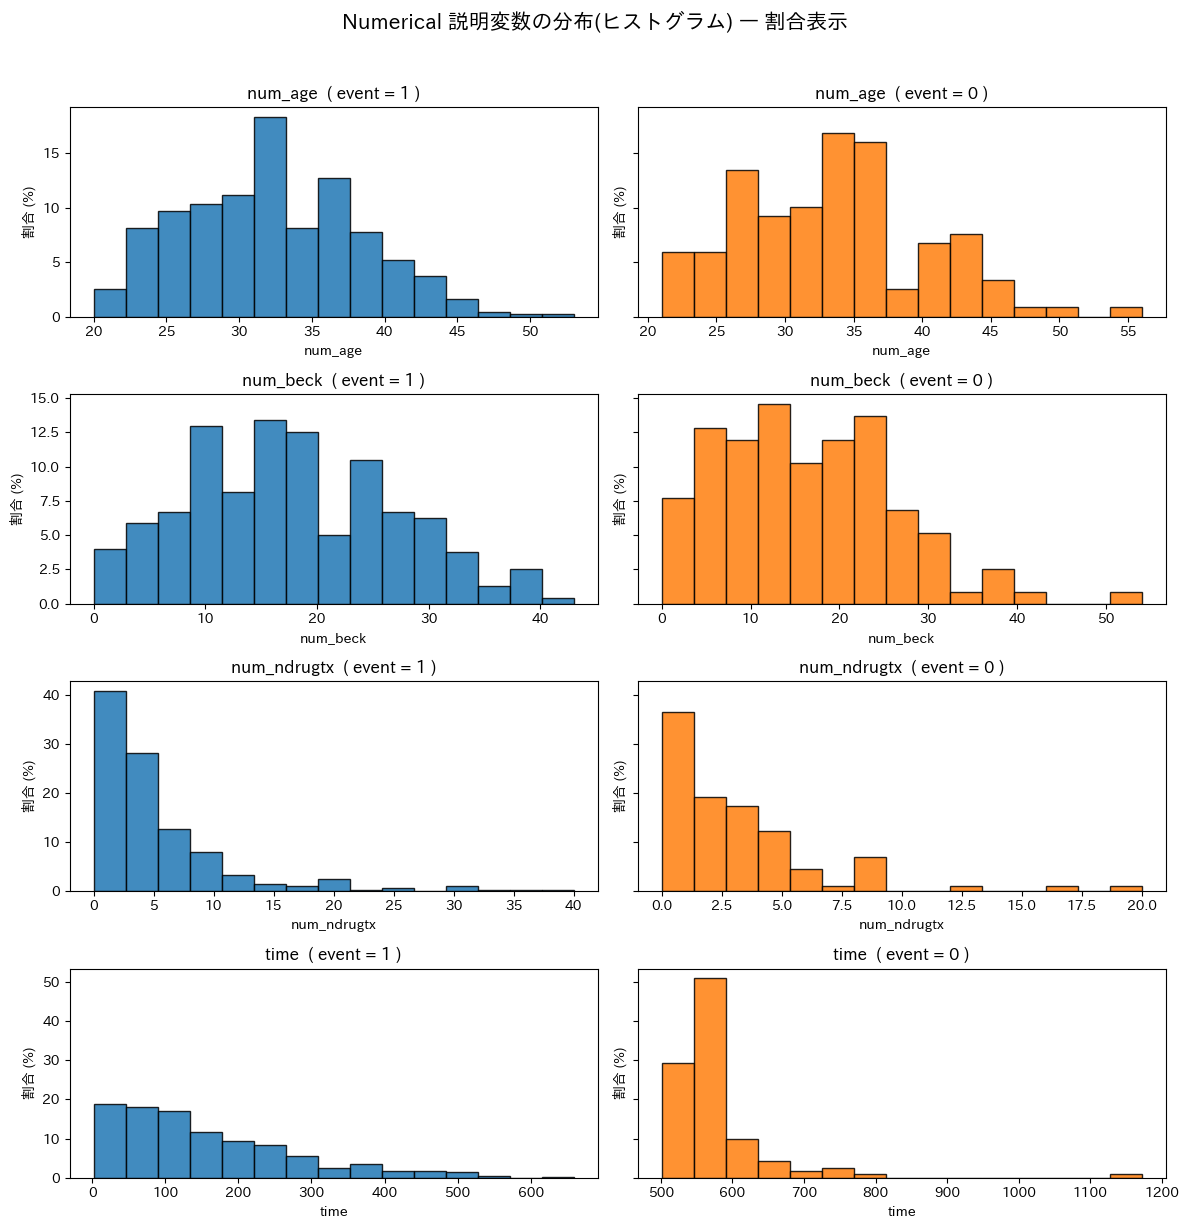

In [86]:

#^ 今回、plotの対象とするのは年齢, ベック鬱スコア, 過去の麻薬治療回数, 時間の4つである
numerical_cols = ["num_age", "num_beck", "num_ndrugtx", "time"]
event_col      = "event"

n_rows = len(numerical_cols)
fig, axes = plt.subplots(
    n_rows, 2, figsize=(12, 3 * n_rows),
    sharey="row"
)

for i, col in enumerate(numerical_cols):
    for j, ev in enumerate([1, 0]):
        ax   = axes[i, j]
        data = df.loc[df[event_col] == ev, col].dropna()
        #^ 割合表示
        weights = np.ones_like(data) / len(data) * 100

        ax.hist(
            data, bins=15, weights=weights,
            alpha=0.85, color=("tab:blue" if ev == 1 else "tab:orange"),
            edgecolor="black"
        )

        ax.set_title(f"{col}  ( {event_col} = {ev} )")
        ax.set_xlabel(col)
        ax.set_ylabel("割合 (%)")

plt.suptitle("Numerical 説明変数の分布(ヒストグラム) — 割合表示", y=1.02, fontsize=15)
plt.tight_layout()
plt.savefig("output/plot/num_説明変数の分布(ヒストグラム).png")
plt.show()

In [87]:

df_treatLONG = df[df["fac_treat"] == 1]
df_treatLONG.shape #^ 長期治療者が308人(308,11)

df_treatSHORT = df[df["fac_treat"] != 1]
df_treatSHORT.shape #^ 短期治療者が320人(320,11) 

(320, 11)

### 治療期間の長さによる、再使用までの時間推移比較
- event==1に限定しており、fac_treat==1の方が再使用までの期間が長い傾向があると伺える。
- 有意な差が生じているかは不明なため、、検定を実施する必要があると言える。

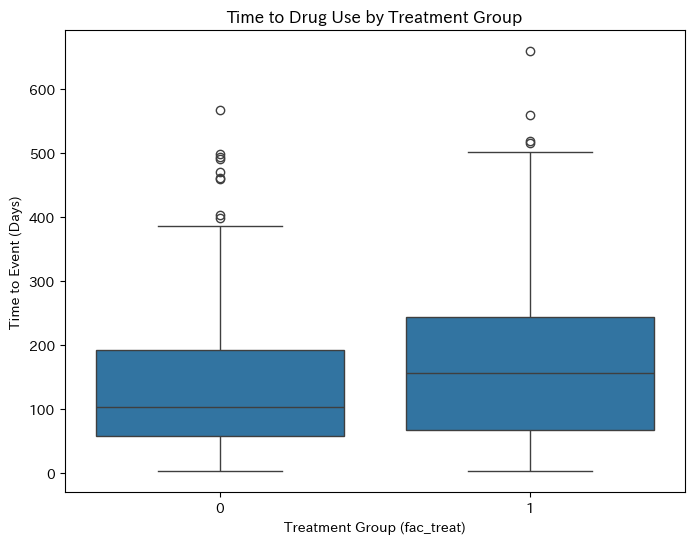

In [88]:

#^  fac_treat（0=Short, 1=Long）ごとの生存時間を可視化
plt.figure(figsize=(8,6))
sns.boxplot(x='fac_treat', y='time', data=df_event1)
plt.title('Time to Drug Use by Treatment Group')
plt.xlabel('Treatment Group (fac_treat)')
plt.ylabel('Time to Event (Days)')
plt.show()

### 静脈注射による薬物投与歴
> 1: Never(一度もない), 2: Previous(過去にあり), 3: Recent(最近)    

静脈注射は、、従来の薬物利用方法と比較すると依存度が高いと推測できる。   
また、本データからも、Neverと利用歴があるセグメントで比較すると、第三四分位点が大きく異なっているため、何らかの差があると推測できる。


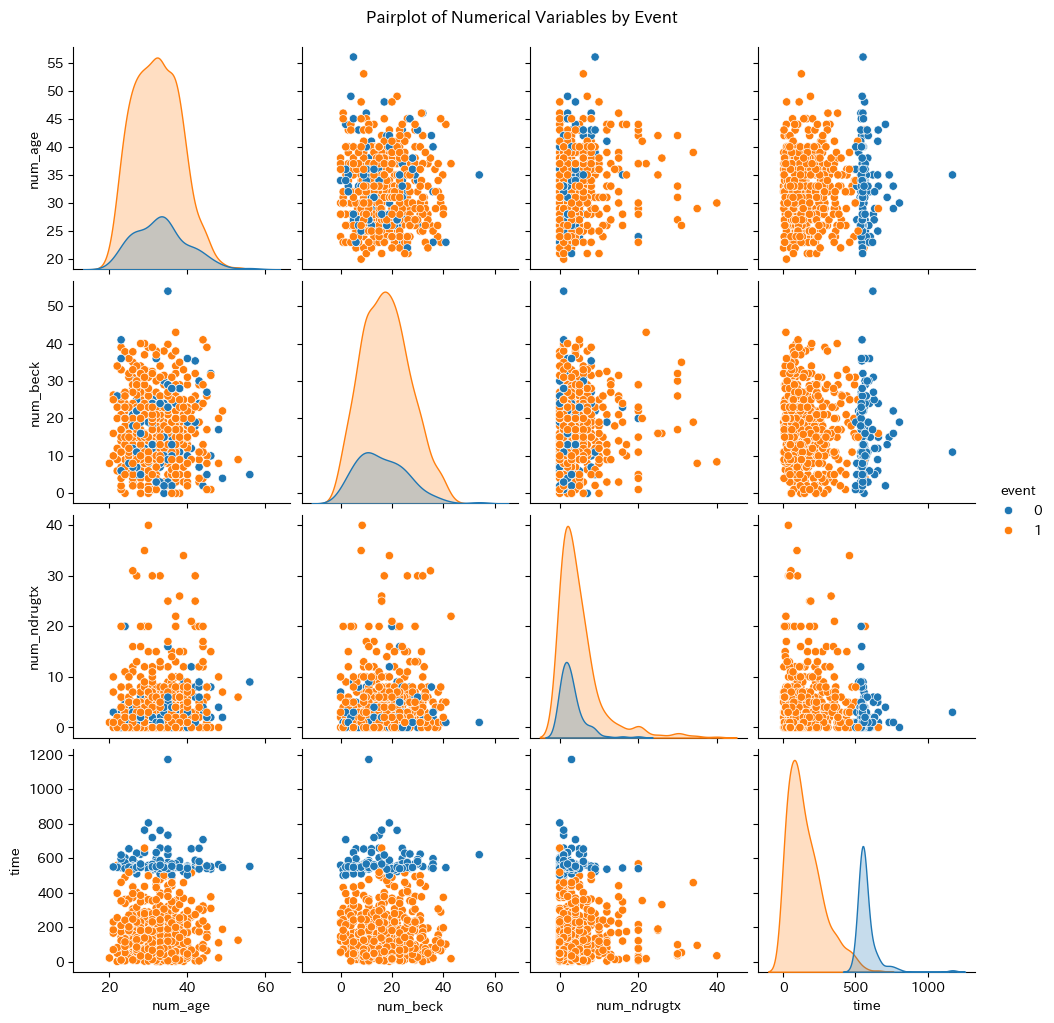

In [91]:
sns.pairplot(df, vars=['num_age', 'num_beck', 'num_ndrugtx', 'time'], hue='event')
plt.suptitle('Pairplot of Numerical Variables by Event', y=1.02)
plt.show()

In [102]:
corr = df.drop(columns=['time','event']).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("共変量の相関行列")
plt.show()

In [93]:
# プロファイルレポートの作成
profile = ProfileReport(df, title="UIS Dataset EDA Report", explorative=True)

# Jupyter Notebookなら
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 100956.99it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [94]:
profile.to_file("output/uis_eda_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 分析
## 仮説
> $H_0: 長期治療により、薬物再使用までの時間に対して効果がない$    
> $H_1 : 長期治療により、薬物再使用までの時間を伸ばす有意な効果がある$

## 

# カプランマイヤー曲線(ノンパラメトリック)を用いた分析

In [132]:
def kaplan_meier_plot(col_name,title,
                      check=True):
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10,6))
    for name, group in df.groupby(col_name):
        T = group['time']
        E = group['event']
        kmf.fit(T, event_observed=E, label=f'fac_heroic  {name}')
        kmf.plot_survival_function(ci_show=True)
        sf = kmf.survival_function_
        if check:
            print(f"--- fac_heroic {name} ---")
            print(sf.head(), "\n")
    plt.title(f'{title}別のKaplan-Meier曲線')
    plt.xlabel('プログラム終了からの経過日数')
    plt.ylabel('生存率(再使用していない人の割合)')
    plt.ylim(0,1)
    plt.grid(True)
    plt.legend()
    plt.show()

- ヘロイン,コカインの使用歴

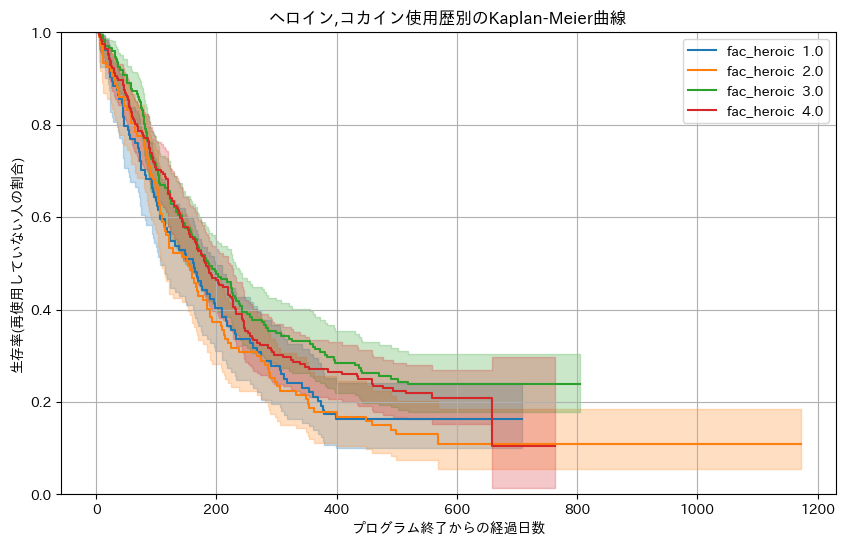

In [131]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(10,6))
for name, group in df.groupby('fac_heroic'):
    T = group['time']
    E = group['event']    # 1=事象，0=打ち切り

    # フィッティング
    kmf.fit(T, event_observed=E, label=f'fac_heroic  {name}')

    # 生存関数をプロット
    kmf.plot_survival_function(ci_show=True)

    # 数値として取り出す場合
    sf = kmf.survival_function_
    #print(f"--- fac_heroic {name} ---")
    #print(sf.head(), "\n")  # 上位5行を表示

plt.title('ヘロイン,コカイン使用歴別のKaplan-Meier曲線')
plt.xlabel('プログラム終了からの経過日数')
plt.ylabel('生存率(再使用していない人の割合)')
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.show()

- Treatの違いによる、生存関数の違いを把握する
- 横軸が時間の流れ
- 縦軸が、生存割合

In [ ]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

plt.figure(figsize=(10,6))
for name, group in df.groupby('fac_treat'):
    T = group['time']
    E = group['event']    # 1=事象，0=打ち切り

    # フィッティング
    kmf.fit(T, event_observed=E, label=f'Treatment {name}')

    # 生存関数をプロット
    kmf.plot_survival_function(ci_show=True)

    # 数値として取り出す場合
    sf = kmf.survival_function_
    print(f"--- Treatment {name} ---")
    print(sf.head(), "\n")  # 上位5行を表示

plt.title('治療プログラム別のKaplan-Meier曲線')
plt.xlabel('プログラム終了からの経過日数')
plt.ylabel('生存率(再使用していない人の割合)')
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.show()

--- Treatment 0 ---
          Treatment 0
timeline             
0.0          1.000000
6.0          0.996540
7.0          0.989619
8.0          0.986159
9.0          0.982699 

--- Treatment 1 ---
          Treatment 1
timeline             
0.0          1.000000
4.0          0.993007
6.0          0.989510
7.0          0.982517
10.0         0.979021 



--- Treatment none_mild ---
          抑うつレベル none_mild
timeline                  
0.0               1.000000
6.0               0.984375
10.0              0.976563
15.0              0.968750
23.0              0.960937 

--- Treatment severe ---
          抑うつレベル severe
timeline               
0.0            1.000000
4.0            0.995526
7.0            0.986577
8.0            0.984340
9.0            0.982103 



/var/folders/wb/sqvg1jfx4qvbgf2ndb8gt5300000gn/T/ipykernel_90136/3335389625.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df.groupby('beck_cat'):


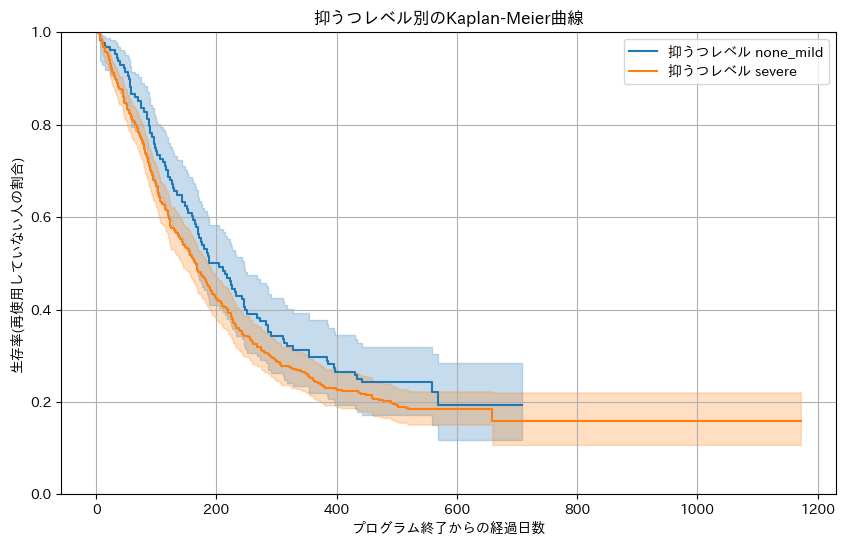

In [127]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

df['beck_cat'] = pd.cut(
    df['num_beck'],
    bins=[-1, 9, df['num_beck'].max()],
    labels=['none_mild', 'severe']
)

kmf = KaplanMeierFitter()

plt.figure(figsize=(10,6))
for name, group in df.groupby('beck_cat'):
    T = group['time']
    E = group['event']    # 1=事象，0=打ち切り

    # フィッティング
    kmf.fit(T, event_observed=E, label=f'抑うつレベル {name}')

    # 生存関数をプロット
    kmf.plot_survival_function(ci_show=True)

    # 数値として取り出す場合
    sf = kmf.survival_function_
    print(f"--- Treatment {name} ---")
    print(sf.head(), "\n")  # 上位5行を表示

plt.title('抑うつレベル別のKaplan-Meier曲線')
plt.xlabel('プログラム終了からの経過日数')
plt.ylabel('生存率(再使用していない人の割合)')
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.show()

# ログランク検定
- 有意の差があるかどうかの検定 -> どのくらいの差があるかは判定できない

In [96]:
result = statistics.logrank_test(
    df.loc[df["fac_treat"]==0, "time"],
    df.loc[df["fac_treat"]==1, "time"],
    event_observed_A=df.loc[df["fac_treat"]==0, "event"],
    event_observed_B=df.loc[df["fac_treat"]==1, "event"],

)

print("=== Log-rank Test: Short vs Long ===")
print(f"Test statistic (χ²) = {result.test_statistic:.3f}")
print(f"p-value              = {result.p_value:.5f}")

=== Log-rank Test: Short vs Long ===
Test statistic (χ²) = 6.798
p-value              = 0.00913


# Schoenfeld残差

In [97]:
df = pd.read_csv("src/uis_data.csv",
                 na_values=['missing']
                 )
df = df.dropna()
df = df.drop(columns=['pid'])


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 575 total observations, 111 right-censored observations>
         test_name = proportional_hazard_test

---
                  test_statistic    p  -log2(p)
Unnamed: 0  km              0.00 0.95      0.07
            rank            0.01 0.93      0.10
fac_heroic  km              0.05 0.82      0.28
            rank            0.05 0.82      0.28
fac_ivhx    km              0.03 0.86      0.22
            rank            0.03 0.86      0.22
fac_race    km              1.25 0.26      1.92
            rank            1.26 0.26      1.94
fac_site    km              0.12 0.73      0.46
            rank            0.13 0.72      0.48
fac_treat   km              3.68 0.06      4.18
            rank            3.70 0.05      4.20
num_age     km              0.30 0.58      0.78
            rank            0.31 0.58      0.80
num_beck    km              2.73 0.10      3.35
            rank            2.74 0.10      3.35
num_ndrugtx km              0.23 0.63      0.67
            rank            0.23 0.63      0.67



1. Variable 'fac_treat' failed the non-proportional test: p-value is 0.0545.

   Advice: with so few unique values (only 2), you can include `strata=['fac_treat', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthed

[[<Axes: xlabel='rank-transformed time\n(p=0.9335)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9539)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8215)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8236)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8604)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8602)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2610)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2642)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0545)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0551)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7179)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7295)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5758)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5814)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0981)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0983)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6303)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6299)'>]]

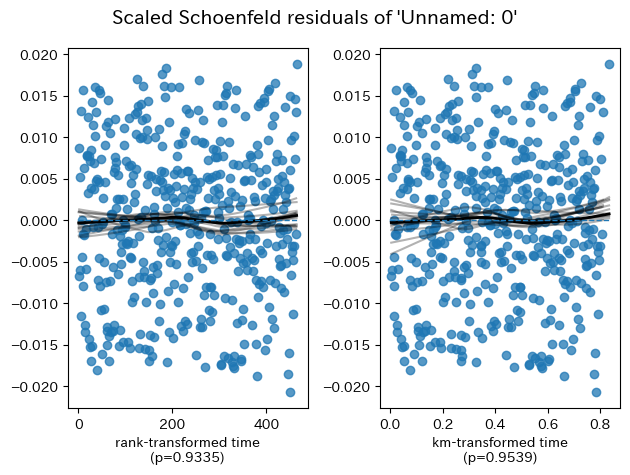

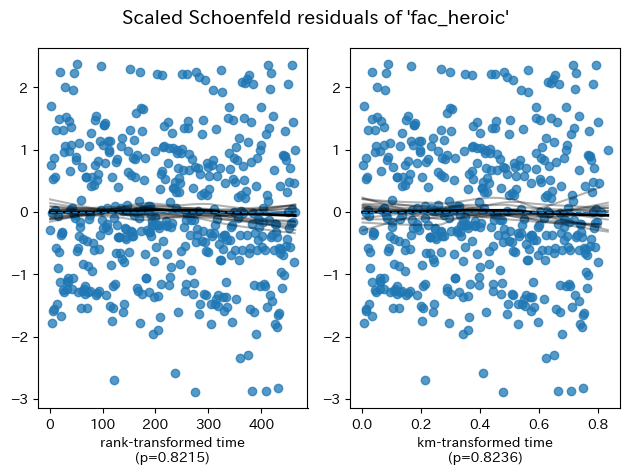

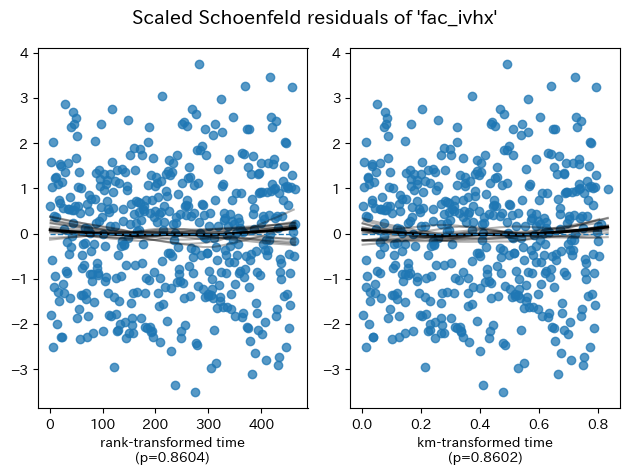

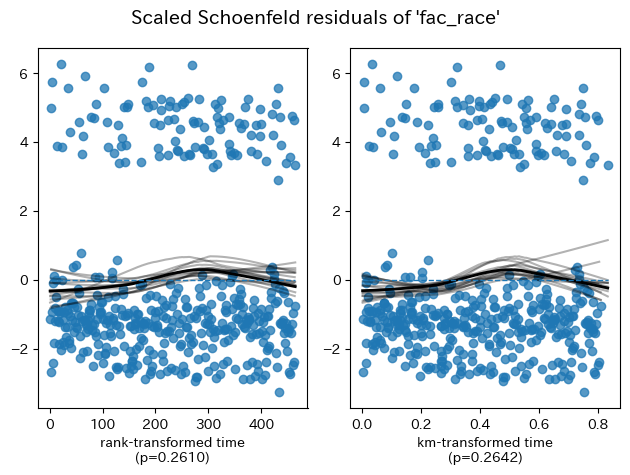

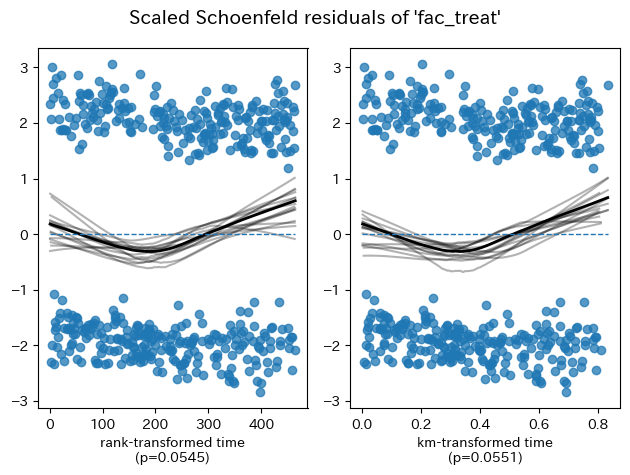

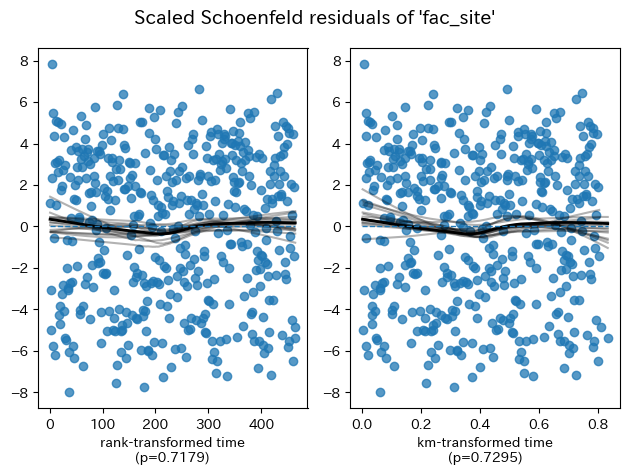

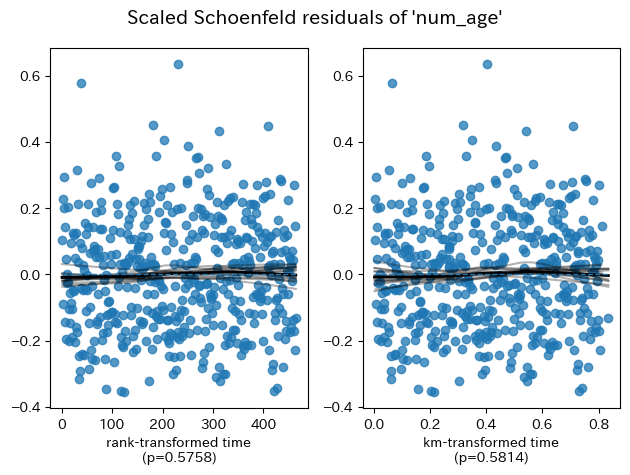

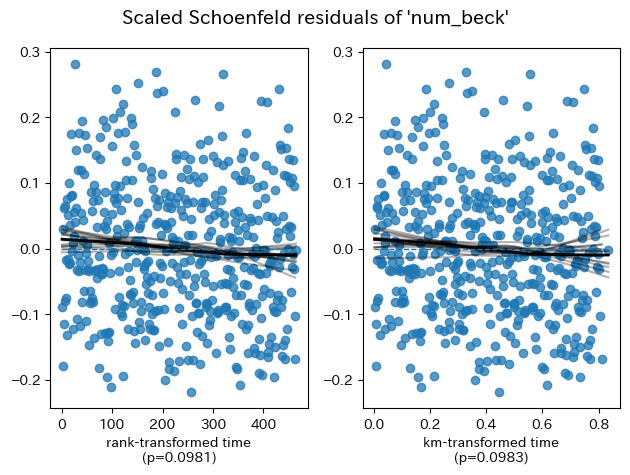

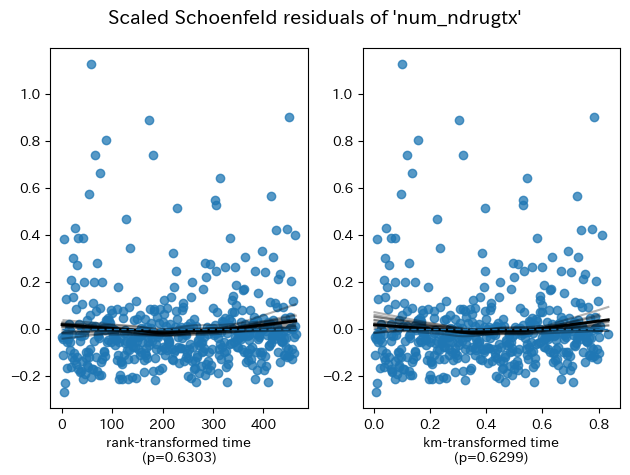

In [99]:
cph = CoxPHFitter()
cph.fit(df, duration_col='time', event_col='event')
cph.check_assumptions(df, p_value_threshold=0.05, show_plots=True)

# Cox回帰(比例ハザードモデル)による、影響度評価
### 特徴
- 何倍長生きしやすいか
- 発生率の割合(比)を求められる

### 条件
- 比例ハザードモデルを利用している(時間によらず一定である)
    - 曲線がクロスすることはない
    - 曲線の間隔の比は一定
    -> 検定は、ログランク検定

### 問題
- 競合リスク
    - 色々な問題が存在することで、当該イベントについての観察ができなくなる場合がある


# 比例ハザード性がない場合の推定

In [100]:
df_dropedna = df.copy().dropna()
cph = CoxPHFitter()
cph.fit(
    df_dropedna[["time", "event", "fac_treat"]],
    duration_col="time",
    event_col="event"
)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 575 total observations, 111 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 575
number of events observed = 464
   partial log-likelihood = -2659.90
         time fit was run = 2025-07-15 15:07:13 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fac_treat -0.24      0.79      0.09           -0.42           -0.06                0.66                0.95

           cmp to     z    p  -log2(p)
covariate                             
fac_treat    0.00 -2.55 0.01      6.54
---
Concordance = 0.54
Partial AIC = 5321.79
log-likelihood ratio test = 6.51 on 1 df
-log2(p) of ll-ratio test = 6.54

In [101]:
df2 = df.copy()

# ―― fac_ivhx: 1=Never, 2=Previous, 3=Recent, missing→1 に統合
df2["fac_ivhx"] = df2["fac_ivhx"].replace("missing", 1)

# ↓ ここでは dropna しない（time, event は欠損なし想定）
num_cols = ["num_age", "num_beck", "num_ndrugtx"]
df2[num_cols] = (
    df2[num_cols]     # 欠損があれば 0 埋め or 平均埋めでも OK
    .fillna(df2[num_cols].mean())
    .pipe(lambda x: (x - x.mean()) / x.std(ddof=0))   # 標準化
)

formula = (
    "fac_treat + num_age + num_beck + num_ndrugtx + "
    "C(fac_ivhx)"         # ← Treatment() 指定を外す
)
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=1.0, l1_ratio=0.3)
cph.fit(df2, "time", "event", formula=formula)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 575 total observations, 111 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 1.0
                 l1 ratio = 0.3
      baseline estimation = breslow
   number of observations = 575
number of events observed = 464
   partial log-likelihood = -2663.15
         time fit was run = 2025-07-15 15:07:13 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
fac_treat          -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
num_age            -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
num_beck            0.00      1.00      0.00           -0.00            0.00                1.00                1.00
num_ndrugtx         0.00      1.00      0.00           -0.00            0.00                1.00                1.00
C(fac_ivhx)[T.2.0] -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
C(fac_ivhx)[T.3.0]  0.00      1.00      0.00           -0.00            0.00                1.00                1.00

                    cmp to     z    p  -log2(p)
covariate                                      
fac_treat             0.00 -0.00 1.00      0.00
num_age               0.00 -0.00 1.00      0.00
num_beck              0.00  0.00 1.00      0.00
num_ndrugtx           0.00  0.00 1.00      0.00
C(fac_ivhx)[T.2.0]    0.00 -0.00 1.00      0.00
C(fac_ivhx)[T.3.0]    0.00  0.00 1.00      0.00
---
Concordance = 0.58
Partial AIC = 5338.30
log-likelihood ratio test = -0.00 on 6 df
-log2(p) of ll-ratio test = -0.00

# まとめ